In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv3d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 16)
        self.dconv_down2 = double_conv(16, 32)
        self.dconv_down3 = double_conv(32, 64)
        self.dconv_down4 = double_conv(64, 128)
        self.dconv_down5 = double_conv(128, 256)

        self.maxpool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(128 + 256, 128)
        self.dconv_up3 = double_conv(64 + 128, 64)
        self.dconv_up2 = double_conv(32 + 64, 32)
        self.dconv_up1 = double_conv(16 + 32, 16)
        
        self.conv_last = nn.Conv3d(16, in_channels, 1)
        self.fc1 = nn.Linear(2048 ,1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.signmoid = nn.Sigmoid()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
        
        x = self.dconv_down5(x) 
        
        #Classifier
        x1 = self.maxpool(x)
        flatten = x1.view(x1.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
    
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        x = self.conv_last(x)
        out = self.relu(x)
        
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.01)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
# from torchsummary import summary

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UNet(3,1)
# model.apply (init_weights)
# model = model.to(device)
# # model
# summary(model, input_size=(1, 80, 80, 80))

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
def calc_loss(out, prediction, target, original, metrics, MSE_weight=0.5):
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
    MSE = F.mse_loss(out*65535, original*65535)
    
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [8]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics,MSE_weight = 1e-7)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T

            summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (2/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 3 and val_MSEloss_history[-1] > 2e6 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [9]:
# Datadir = "E:\\WBC_Type_Classification_v4\\Dataset\\3DImagesDeconv-aug-fortrain\\Fold-1"
# Datadir = "E:\\WBC_Type_Classification_v4\\Dataset\\3DImages-aug"
Datadir = "F:\\CellLineClassification\\DataForTrain\\3DImages"

In [10]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)

In [11]:
import os

def datapreparation(Datadir):
    trainpath = []
    trainlabel = []
    fpath = []
    traindir = Datadir + "\\HEK"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HEK data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)

    fpath = []
    traindir = Datadir + "\\HELA"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HELA data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i]) 
        trainlabel.append(1)

    fpath = []
    traindir = Datadir + "\\MCF7"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('MCF7 data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(2)
    return trainpath,trainlabel

In [12]:
X, Y = datapreparation(Datadir)

HEK data: 3191
HELA data: 3315
MCF7 data: 3764


In [13]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    3     5     6 ... 10262 10263 10264]
Train Index:  [    3     5     6 ... 10266 10267 10269] 

Test Index:  [    0     1     2 ... 10258 10259 10268]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    9    10    11 ... 10249 10253 10265]
Train Index:  [    0     1     2 ... 10266 10268 10269] 

Test Index:  [    7    13    17 ... 10252 10257 10267]
Train Index:  [    0     1     2 ... 10265 10267 10268] 

Test Index:  [   20    21    27 ... 10255 10266 10269]


In [14]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'HEK' in self.paths[index]:
            label = int(0)
        elif 'HELA' in self.paths[index]:
            label = int(1)
        elif 'MCF7' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [15]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['HEK-293','HeLa','MCF-7']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Granulocytes Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  8216
validation data volume:  2054
Granulocytes Label:  HEK-293
image tensor shape:  torch.Size([1, 80, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80, 80)


C:\Users\tonyt\.conda\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


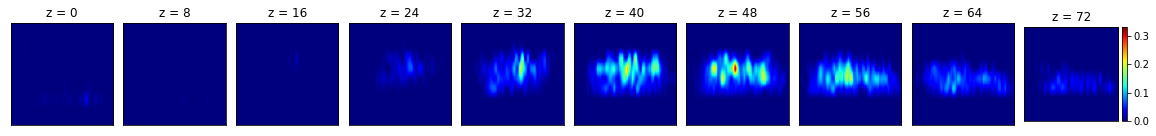

In [16]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
# image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,MinLim,MaxLim): 
    plt.figure(figsize=(20,20))
    for depth in range (0,80,8):
        
        plt.subplot(1,10,depth/8+1)
        fig4 = plt.imshow(img[:,:,depth],vmin=MinLim, vmax=MaxLim, cmap ='jet')
        fig4.axes.get_xaxis().set_visible(False)
        fig4.axes.get_yaxis().set_visible(False)
        # plt.colorbar()
        plt.title('z = '+ str(depth))
        if depth==72:
            plt.subplot(1,10,depth/8+1)
            plt.title('z = '+ str(depth))
            ax = plt.gca()
            fig4 = plt.imshow(img[:,:,depth],vmin=MinLim, vmax=MaxLim, cmap ='jet')
            fig4.axes.get_xaxis().set_visible(False)
            fig4.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
DisplayImage(image,image.min(),image.max())

In [17]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}
# dataloaders_dict = {}
# dataloaders_dict ['train'] = torch.utils.data.DataLoader(image_datasets['train'],batch_size=batch_size, num_workers=0, sampler=weighted_sampler)
# dataloaders_dict ['val'] = torch.utils.data.DataLoader(image_datasets['val'],batch_size=batch_size, shuffle=True, num_workers=0)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 0.524156, MSE: 7357348.155581, loss: 1.259891
train Acc: 0.7814
train Bal. Acc: 0.7844
val: CE: 1.337180, MSE: 584186.589520, loss: 1.395599
val Acc: 0.5623
val Bal. Acc: 0.5426
saving best model
Total time: 0:07:36.779623
Epoch time: 7m 37s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.261300, MSE: 384483.958678, loss: 0.299749
train Acc: 0.9058
train Bal. Acc: 0.9061
val: CE: 2.550093, MSE: 262030.040242, loss: 2.576296
val Acc: 0.4202
val Bal. Acc: 0.3893
Total time: 0:15:13.092145
Epoch time: 7m 36s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.181927, MSE: 205294.601829, loss: 0.202457
train Acc: 0.9367
train Bal. Acc: 0.9372
val: CE: 0.456766, MSE: 165589.483386, loss: 0.473325
val Acc: 0.8048
val Bal. Acc: 0.7980
saving best model
Total time: 0:23:01.643369
Epoch time: 7m 49s
Epoch 3/99
----------
LR 0.0001
train: CE: 0.144538, MSE: 138047.624871, loss: 0.158342
train Acc: 0.9490
train Ba

train: CE: 0.012104, MSE: 5858.433757, loss: 0.012690
train Acc: 0.9962
train Bal. Acc: 0.9962
val: CE: 0.103564, MSE: 5417.410603, loss: 0.104106
val Acc: 0.9713
val Bal. Acc: 0.9706
Total time: 14:40:39.732051
Epoch time: 7m 39s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.019161, MSE: 5767.193048, loss: 0.019738
train Acc: 0.9937
train Bal. Acc: 0.9937
val: CE: 0.228234, MSE: 6105.741361, loss: 0.228845
val Acc: 0.9460
val Bal. Acc: 0.9480
Total time: 14:48:19.463202
Epoch time: 7m 40s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.010517, MSE: 5582.444459, loss: 0.011075
train Acc: 0.9961
train Bal. Acc: 0.9962
val: CE: 0.107960, MSE: 5110.297024, loss: 0.108471
val Acc: 0.9757
val Bal. Acc: 0.9767
Total time: 14:55:58.822822
Epoch time: 7m 39s
Epoch 33/99
----------
LR 0.0001
train: CE: 0.006746, MSE: 5739.243630, loss: 0.007320
train Acc: 0.9981
train Bal. Acc: 0.9981
val: CE: 1.557159, MSE: 4695.179126, loss: 1.557628
val Acc: 0.6714
val Bal. Acc: 0.6942
Total time: 15:03:37.954

train: CE: 0.002552, MSE: 2105.365857, loss: 0.002762
train Acc: 0.9993
train Bal. Acc: 0.9993
val: CE: 0.497202, MSE: 2276.709614, loss: 0.497429
val Acc: 0.9094
val Bal. Acc: 0.9067
Total time: 18:39:18.583223
Epoch time: 7m 46s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.007254, MSE: 1967.220750, loss: 0.007450
train Acc: 0.9976
train Bal. Acc: 0.9976
val: CE: 0.097241, MSE: 1810.532713, loss: 0.097422
val Acc: 0.9781
val Bal. Acc: 0.9783
Total time: 18:47:04.641156
Epoch time: 7m 46s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.003692, MSE: 1985.278622, loss: 0.003890
train Acc: 0.9988
train Bal. Acc: 0.9988
val: CE: 0.125433, MSE: 2410.286459, loss: 0.125674
val Acc: 0.9722
val Bal. Acc: 0.9718
Total time: 18:54:50.486387
Epoch time: 7m 46s
Epoch 64/99
----------
LR 0.0001
train: CE: 0.002411, MSE: 2018.139628, loss: 0.002613
train Acc: 0.9991
train Bal. Acc: 0.9992
val: CE: 0.113149, MSE: 2241.512259, loss: 0.113373
val Acc: 0.9781
val Bal. Acc: 0.9795
Total time: 19:02:36.343

train: CE: 0.000138, MSE: 925.452939, loss: 0.000231
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.076444, MSE: 974.876094, loss: 0.076541
val Acc: 0.9830
val Bal. Acc: 0.9837
Total time: 22:39:56.804940
Epoch time: 7m 46s
Epoch 93/99
----------
LR 2.5e-05
train: CE: 0.000112, MSE: 909.767852, loss: 0.000203
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.076651, MSE: 953.839130, loss: 0.076746
val Acc: 0.9859
val Bal. Acc: 0.9862
Total time: 22:47:43.120857
Epoch time: 7m 46s
Epoch 94/99
----------
LR 2.5e-05
train: CE: 0.000174, MSE: 896.939825, loss: 0.000264
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.081229, MSE: 950.442609, loss: 0.081324
val Acc: 0.9844
val Bal. Acc: 0.9850
Total time: 22:55:29.665677
Epoch time: 7m 47s
Epoch 95/99
----------
LR 2.5e-05
train: CE: 0.000741, MSE: 888.535068, loss: 0.000829
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.114669, MSE: 946.178655, loss: 0.114764
val Acc: 0.9791
val Bal. Acc: 0.9798
Total time: 23:03:16.122041
E

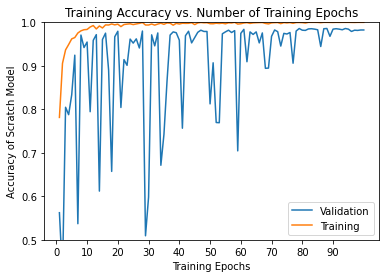

100


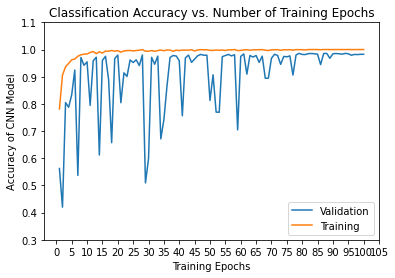

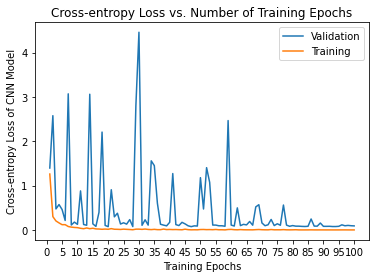

tensor([[637.,   0.,   2.],
        [  2., 650.,  11.],
        [  2.,  12., 738.]])
[641. 662. 751.]
[[0.9968701  0.         0.00312989]
 [0.00301659 0.98039216 0.01659125]
 [0.00265957 0.01595745 0.98138297]]



Fold- 1 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001


C:\Users\tonyt\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train: CE: 0.563425, MSE: 9048658.479217, loss: 1.468290
train Acc: 0.7638
train Bal. Acc: 0.7662
val: CE: 1.652206, MSE: 428011.520691, loss: 1.695007
val Acc: 0.4898
val Bal. Acc: 0.4649
saving best model
Total time: 0:07:45.880191
Epoch time: 7m 46s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.265950, MSE: 283916.991952, loss: 0.294341
train Acc: 0.9054
train Bal. Acc: 0.9065
val: CE: 0.825521, MSE: 213276.953597, loss: 0.846849
val Acc: 0.7132
val Bal. Acc: 0.7026
saving best model
Total time: 0:15:31.614062
Epoch time: 7m 46s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.178945, MSE: 140447.618564, loss: 0.192990
train Acc: 0.9352
train Bal. Acc: 0.9359
val: CE: 0.569247, MSE: 115113.870451, loss: 0.580758
val Acc: 0.7600
val Bal. Acc: 0.7792
saving best model
Total time: 0:23:17.415413
Epoch time: 7m 46s
Epoch 3/99
----------
LR 0.0001
train: CE: 0.125511, MSE: 95633.014514, loss: 0.135074
train Acc: 0.9562
train Bal. Acc: 0.9566
val: CE: 1.169991, MSE: 106674.101251, loss: 1.1806

val: CE: 0.093421, MSE: 4543.144784, loss: 0.093875
val Acc: 0.9737
val Bal. Acc: 0.9734
Total time: 3:58:50.007224
Epoch time: 7m 41s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.009138, MSE: 5120.192281, loss: 0.009650
train Acc: 0.9972
train Bal. Acc: 0.9973
val: CE: 0.071667, MSE: 3872.972308, loss: 0.072054
val Acc: 0.9752
val Bal. Acc: 0.9750
Total time: 4:06:30.715086
Epoch time: 7m 41s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.003528, MSE: 8504.595014, loss: 0.004379
train Acc: 0.9994
train Bal. Acc: 0.9994
val: CE: 0.352785, MSE: 6585.869736, loss: 0.353443
val Acc: 0.9041
val Bal. Acc: 0.9009
Total time: 4:14:11.478475
Epoch time: 7m 41s
Epoch 33/99
----------
LR 0.0001
train: CE: 0.003373, MSE: 3780.118122, loss: 0.003751
train Acc: 0.9989
train Bal. Acc: 0.9989
val: CE: 0.075516, MSE: 3525.440267, loss: 0.075869
val Acc: 0.9781
val Bal. Acc: 0.9785
Total time: 4:21:51.960244
Epoch time: 7m 40s
Epoch 34/99
----------
LR 0.0001
train: CE: 0.010530, MSE: 4493.847578, loss

train: CE: 0.001652, MSE: 1923.849457, loss: 0.001844
train Acc: 0.9994
train Bal. Acc: 0.9994
val: CE: 0.057135, MSE: 1680.217797, loss: 0.057303
val Acc: 0.9820
val Bal. Acc: 0.9818
Total time: 8:04:35.620816
Epoch time: 7m 41s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.006630, MSE: 2877.273940, loss: 0.006917
train Acc: 0.9979
train Bal. Acc: 0.9980
val: CE: 0.084057, MSE: 3238.770325, loss: 0.084380
val Acc: 0.9752
val Bal. Acc: 0.9751
Total time: 8:12:16.180133
Epoch time: 7m 41s
Epoch 64/99
----------
LR 0.0001
train: CE: 0.002118, MSE: 1822.441279, loss: 0.002301
train Acc: 0.9995
train Bal. Acc: 0.9995
val: CE: 0.061499, MSE: 1725.383912, loss: 0.061671
val Acc: 0.9825
val Bal. Acc: 0.9826
Total time: 8:19:56.815578
Epoch time: 7m 41s
Epoch 65/99
----------
LR 0.0001
train: CE: 0.000518, MSE: 2130.654275, loss: 0.000731
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.065308, MSE: 2422.627412, loss: 0.065551
val Acc: 0.9834
val Bal. Acc: 0.9837
Total time: 8:27:37.958122


train: CE: 0.000284, MSE: 1021.153193, loss: 0.000386
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.057579, MSE: 1026.123906, loss: 0.057682
val Acc: 0.9825
val Bal. Acc: 0.9825
Total time: 12:02:34.975916
Epoch time: 7m 40s
Epoch 94/99
----------
LR 2.5e-05
train: CE: 0.000150, MSE: 999.723003, loss: 0.000250
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.054714, MSE: 1041.723113, loss: 0.054818
val Acc: 0.9849
val Bal. Acc: 0.9851
Total time: 12:10:15.092318
Epoch time: 7m 40s
Epoch 95/99
----------
LR 2.5e-05
train: CE: 0.000105, MSE: 1018.556917, loss: 0.000207
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.057429, MSE: 974.714139, loss: 0.057527
val Acc: 0.9834
val Bal. Acc: 0.9837
Epoch    29: reducing learning rate of group 0 to 1.2500e-05.
Total time: 12:17:55.734891
Epoch time: 7m 41s
Epoch 96/99
----------
LR 1.25e-05
train: CE: 0.000100, MSE: 952.675011, loss: 0.000195
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.055267, MSE: 957.408803, loss: 0.055362

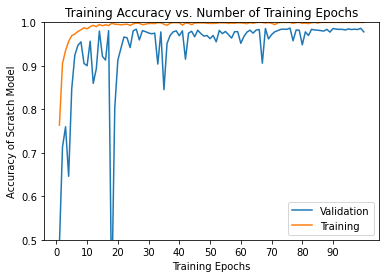

100


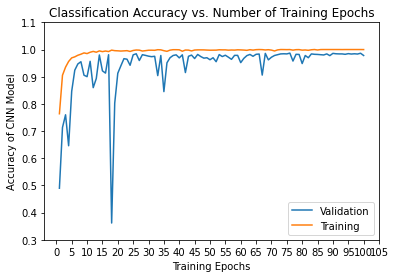

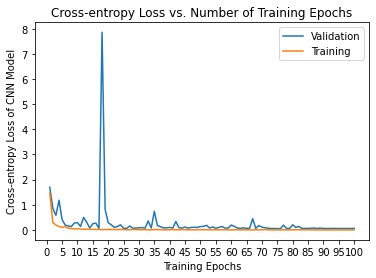

tensor([[635.,   0.,   3.],
        [  5., 652.,   6.],
        [  3.,  10., 740.]])
[643. 662. 749.]
[[0.9952978  0.         0.00470219]
 [0.00754148 0.98340875 0.00904977]
 [0.00398406 0.01328021 0.98273575]]



Fold- 2 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 0.537482, MSE: 7440990.355678, loss: 1.281581
train Acc: 0.7752
train Bal. Acc: 0.7774
val: CE: 0.571713, MSE: 322967.044547, loss: 0.604010
val Acc: 0.7795
val Bal. Acc: 0.7877
saving best model
Total time: 0:07:40.057748
Epoch time: 7m 40s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.256722, MSE: 242306.027812, loss: 0.280952
train Acc: 0.9058
train Bal. Acc: 0.9062
val: CE: 0.266638, MSE: 168532.073865, loss: 0.283492
val Acc: 0.8895
val Bal. Acc: 0.8906
saving best model
Total time: 0:15:20.610588
Epoch time: 7m 41s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.162994, MSE: 135518.814706, loss: 0.176546
train Acc: 0.9430
train Bal. Acc: 0.9439
val: CE: 0.652889, MSE: 111264.625114

val: CE: 0.074980, MSE: 6107.568745, loss: 0.075591
val Acc: 0.9766
val Bal. Acc: 0.9774
Total time: 3:50:22.858918
Epoch time: 7m 40s
Epoch 30/99
----------
LR 0.0001
train: CE: 0.005923, MSE: 7025.366696, loss: 0.006626
train Acc: 0.9981
train Bal. Acc: 0.9980
val: CE: 0.119006, MSE: 5995.871433, loss: 0.119606
val Acc: 0.9674
val Bal. Acc: 0.9665
Total time: 3:58:02.719392
Epoch time: 7m 40s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.012099, MSE: 9724.779876, loss: 0.013071
train Acc: 0.9960
train Bal. Acc: 0.9961
val: CE: 0.076740, MSE: 5596.935275, loss: 0.077300
val Acc: 0.9786
val Bal. Acc: 0.9797
Total time: 4:05:43.641536
Epoch time: 7m 41s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.007352, MSE: 5833.936589, loss: 0.007935
train Acc: 0.9971
train Bal. Acc: 0.9971
val: CE: 0.132466, MSE: 6111.654130, loss: 0.133077
val Acc: 0.9659
val Bal. Acc: 0.9672
Total time: 4:13:24.219250
Epoch time: 7m 41s
Epoch 33/99
----------
LR 0.0001
train: CE: 0.005517, MSE: 6283.946449, loss

train: CE: 0.004264, MSE: 2243.761439, loss: 0.004489
train Acc: 0.9979
train Bal. Acc: 0.9980
val: CE: 0.081525, MSE: 2061.619463, loss: 0.081731
val Acc: 0.9825
val Bal. Acc: 0.9831
Total time: 7:55:58.085736
Epoch time: 7m 41s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.005486, MSE: 2314.217354, loss: 0.005718
train Acc: 0.9981
train Bal. Acc: 0.9980
val: CE: 0.079039, MSE: 2296.690572, loss: 0.079268
val Acc: 0.9810
val Bal. Acc: 0.9815
Total time: 8:03:38.941102
Epoch time: 7m 41s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.002427, MSE: 5656.587344, loss: 0.002993
train Acc: 0.9995
train Bal. Acc: 0.9995
val: CE: 0.070596, MSE: 3018.796431, loss: 0.070898
val Acc: 0.9834
val Bal. Acc: 0.9841
Total time: 8:11:20.371461
Epoch time: 7m 41s
Epoch 64/99
----------
LR 0.0001
train: CE: 0.004305, MSE: 2155.489801, loss: 0.004520
train Acc: 0.9985
train Bal. Acc: 0.9986
val: CE: 1.081890, MSE: 2673.042189, loss: 1.082157
val Acc: 0.8130
val Bal. Acc: 0.8065
Total time: 8:19:00.513468


train: CE: 0.000158, MSE: 1187.934518, loss: 0.000277
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.049625, MSE: 1136.167099, loss: 0.049738
val Acc: 0.9893
val Bal. Acc: 0.9894
Total time: 11:53:51.240310
Epoch time: 7m 41s
Epoch 93/99
----------
LR 2.5e-05
train: CE: 0.000190, MSE: 1185.741483, loss: 0.000309
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.047958, MSE: 1153.895155, loss: 0.048073
val Acc: 0.9903
val Bal. Acc: 0.9904
saving best model
Total time: 12:01:34.457613
Epoch time: 7m 43s
Epoch 94/99
----------
LR 2.5e-05
train: CE: 0.000086, MSE: 1207.221047, loss: 0.000207
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.046898, MSE: 1226.919595, loss: 0.047021
val Acc: 0.9883
val Bal. Acc: 0.9884
Total time: 12:09:15.552891
Epoch time: 7m 41s
Epoch 95/99
----------
LR 2.5e-05
train: CE: 0.000082, MSE: 1214.541129, loss: 0.000204
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.050678, MSE: 1084.879201, loss: 0.050787
val Acc: 0.9878
val Bal. Acc: 0.9879
Tot

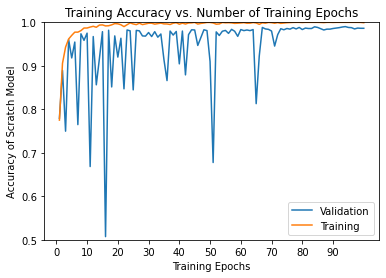

100


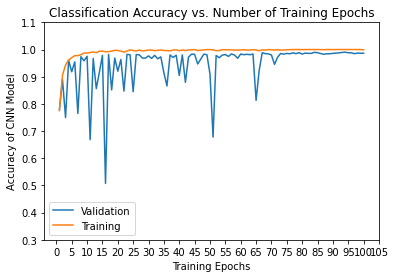

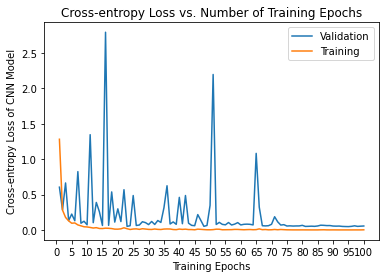

tensor([[635.,   1.,   2.],
        [  2., 654.,   7.],
        [  0.,   8., 745.]])
[637. 663. 754.]
[[0.9952978  0.0015674  0.0031348 ]
 [0.00301659 0.98642534 0.01055807]
 [0.         0.01062417 0.9893758 ]]



Fold- 3 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 0.462902, MSE: 70082514.453749, loss: 7.471154
train Acc: 0.8152
train Bal. Acc: 0.8171
val: CE: 4.886455, MSE: 70176893.639727, loss: 11.904144
val Acc: 0.4153
val Bal. Acc: 0.4326
saving best model
Total time: 0:07:37.027934
Epoch time: 7m 37s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.207466, MSE: 70082514.196689, loss: 7.215718
train Acc: 0.9269
train Bal. Acc: 0.9277
val: CE: 1.048133, MSE: 70176894.179163, loss: 8.065823
val Acc: 0.6285
val Bal. Acc: 0.6088
saving best model
Total time: 0:15:14.140947
Epoch time: 7m 37s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.131878, MSE: 70082514.087634, loss: 7.140129
train Acc: 0.9550
train Bal. Acc: 0.9553
val: CE: 2.342302, MSE: 701

train: CE: 0.014105, MSE: 32242.618567, loss: 0.017330
train Acc: 0.9956
train Bal. Acc: 0.9957
val: CE: 0.125196, MSE: 10291.714674, loss: 0.126225
val Acc: 0.9674
val Bal. Acc: 0.9695
Total time: 2:25:45.829339
Epoch time: 7m 39s
Epoch 19/99
----------
LR 0.0001
train: CE: 0.018728, MSE: 9963.858163, loss: 0.019724
train Acc: 0.9949
train Bal. Acc: 0.9949
val: CE: 0.183615, MSE: 9328.735372, loss: 0.184548
val Acc: 0.9523
val Bal. Acc: 0.9509
Total time: 2:33:25.457703
Epoch time: 7m 40s
Epoch 20/99
----------
LR 0.0001
train: CE: 0.010635, MSE: 9154.471851, loss: 0.011550
train Acc: 0.9968
train Bal. Acc: 0.9969
val: CE: 0.094620, MSE: 8754.716121, loss: 0.095496
val Acc: 0.9718
val Bal. Acc: 0.9736
Total time: 2:41:05.536906
Epoch time: 7m 40s
Epoch 21/99
----------
LR 0.0001
train: CE: 0.022847, MSE: 8714.056947, loss: 0.023718
train Acc: 0.9925
train Bal. Acc: 0.9925
val: CE: 6.164196, MSE: 8890.933595, loss: 6.165085
val Acc: 0.4065
val Bal. Acc: 0.3751
Total time: 2:48:45.73633

val: CE: 0.429865, MSE: 3341.746813, loss: 0.430199
val Acc: 0.8905
val Bal. Acc: 0.8945
Total time: 6:23:24.335762
Epoch time: 7m 40s
Epoch 50/99
----------
LR 0.0001
train: CE: 0.008957, MSE: 3321.077204, loss: 0.009289
train Acc: 0.9968
train Bal. Acc: 0.9969
val: CE: 0.097192, MSE: 2276.338393, loss: 0.097419
val Acc: 0.9747
val Bal. Acc: 0.9756
Total time: 6:31:03.972162
Epoch time: 7m 40s
Epoch 51/99
----------
LR 0.0001
train: CE: 0.008953, MSE: 3234.190274, loss: 0.009277
train Acc: 0.9971
train Bal. Acc: 0.9971
val: CE: 0.116853, MSE: 2797.732302, loss: 0.117133
val Acc: 0.9752
val Bal. Acc: 0.9767
Total time: 6:38:43.785068
Epoch time: 7m 40s
Epoch 52/99
----------
LR 0.0001
train: CE: 0.004179, MSE: 2283.644729, loss: 0.004408
train Acc: 0.9987
train Bal. Acc: 0.9987
val: CE: 0.127640, MSE: 2069.381829, loss: 0.127847
val Acc: 0.9693
val Bal. Acc: 0.9713
Total time: 6:46:23.660677
Epoch time: 7m 40s
Epoch 53/99
----------
LR 0.0001
train: CE: 0.006074, MSE: 3298.459410, loss

val: CE: 0.072905, MSE: 996.407752, loss: 0.073005
val Acc: 0.9839
val Bal. Acc: 0.9839
Total time: 10:21:06.655699
Epoch time: 7m 40s
Epoch 81/99
----------
LR 5e-05
train: CE: 0.000175, MSE: 989.340602, loss: 0.000273
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.068261, MSE: 974.394552, loss: 0.068359
val Acc: 0.9869
val Bal. Acc: 0.9871
saving best model
Total time: 10:28:46.762968
Epoch time: 7m 40s
Epoch 82/99
----------
LR 5e-05
train: CE: 0.000147, MSE: 969.487786, loss: 0.000244
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.071463, MSE: 958.649513, loss: 0.071559
val Acc: 0.9854
val Bal. Acc: 0.9854
Total time: 10:36:26.745616
Epoch time: 7m 40s
Epoch 83/99
----------
LR 5e-05
train: CE: 0.000286, MSE: 987.077658, loss: 0.000384
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.136441, MSE: 1176.220104, loss: 0.136559
val Acc: 0.9766
val Bal. Acc: 0.9761
Total time: 10:44:06.686136
Epoch time: 7m 40s
Epoch 84/99
----------
LR 5e-05
train: CE: 0.000218, MSE: 985.7

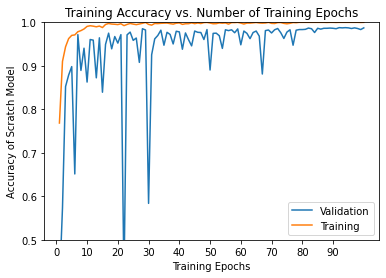

100


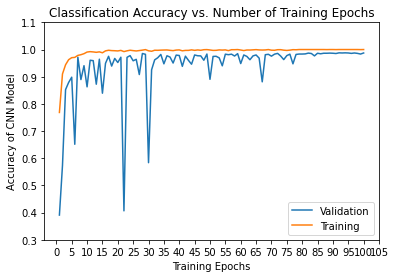

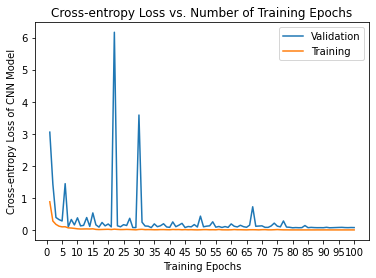

tensor([[637.,   1.,   0.],
        [  2., 649.,  12.],
        [  0.,  10., 743.]])
[639. 660. 755.]
[[0.9984326  0.0015674  0.        ]
 [0.00301659 0.97888386 0.01809955]
 [0.         0.01328021 0.9867198 ]]



Fold- 4 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 0.0001
train: CE: 0.559200, MSE: 2655425.322055, loss: 0.824742
train Acc: 0.7555
train Bal. Acc: 0.7576
val: CE: 0.341726, MSE: 327220.313428, loss: 0.374448
val Acc: 0.8724
val Bal. Acc: 0.8713
saving best model
Total time: 0:07:40.970019
Epoch time: 7m 41s
Epoch 1/99
----------
LR 0.0001
train: CE: 0.258271, MSE: 177485.656166, loss: 0.276020
train Acc: 0.9066
train Bal. Acc: 0.9073
val: CE: 0.182779, MSE: 105160.670422, loss: 0.193295
val Acc: 0.9435
val Bal. Acc: 0.9455
saving best model
Total time: 0:15:21.876747
Epoch time: 7m 41s
Epoch 2/99
----------
LR 0.0001
train: CE: 0.168680, MSE: 85330.214372, loss: 0.177213
train Acc: 0.9408
train Bal. Acc: 0.9415
val: CE: 1.037889, MSE: 67294.122048, 

train: CE: 0.010536, MSE: 4007.043581, loss: 0.010937
train Acc: 0.9965
train Bal. Acc: 0.9965
val: CE: 0.094369, MSE: 3872.329669, loss: 0.094756
val Acc: 0.9713
val Bal. Acc: 0.9734
Total time: 3:57:58.067195
Epoch time: 7m 40s
Epoch 31/99
----------
LR 0.0001
train: CE: 0.009237, MSE: 3740.106724, loss: 0.009611
train Acc: 0.9967
train Bal. Acc: 0.9968
val: CE: 0.143047, MSE: 3651.232100, loss: 0.143412
val Acc: 0.9562
val Bal. Acc: 0.9596
Total time: 4:05:37.917125
Epoch time: 7m 40s
Epoch 32/99
----------
LR 0.0001
train: CE: 0.016558, MSE: 4313.534690, loss: 0.016989
train Acc: 0.9949
train Bal. Acc: 0.9949
val: CE: 0.069945, MSE: 3839.011985, loss: 0.070328
val Acc: 0.9791
val Bal. Acc: 0.9795
Total time: 4:13:18.244416
Epoch time: 7m 40s
Epoch 33/99
----------
LR 0.0001
train: CE: 0.006458, MSE: 3750.408883, loss: 0.006833
train Acc: 0.9977
train Bal. Acc: 0.9977
val: CE: 0.080778, MSE: 3431.250970, loss: 0.081121
val Acc: 0.9742
val Bal. Acc: 0.9759
Total time: 4:20:58.169045


val: CE: 0.046050, MSE: 1684.322471, loss: 0.046218
val Acc: 0.9883
val Bal. Acc: 0.9883
Total time: 7:55:40.395510
Epoch time: 7m 40s
Epoch 62/99
----------
LR 0.0001
train: CE: 0.013752, MSE: 1711.263013, loss: 0.013923
train Acc: 0.9962
train Bal. Acc: 0.9962
val: CE: 0.099043, MSE: 1956.997770, loss: 0.099238
val Acc: 0.9727
val Bal. Acc: 0.9721
Total time: 8:03:20.325602
Epoch time: 7m 40s
Epoch 63/99
----------
LR 0.0001
train: CE: 0.006903, MSE: 1944.298245, loss: 0.007097
train Acc: 0.9977
train Bal. Acc: 0.9978
val: CE: 0.076345, MSE: 1514.470119, loss: 0.076496
val Acc: 0.9800
val Bal. Acc: 0.9813
Total time: 8:11:00.294706
Epoch time: 7m 40s
Epoch 64/99
----------
LR 0.0001
train: CE: 0.004296, MSE: 1632.501886, loss: 0.004459
train Acc: 0.9989
train Bal. Acc: 0.9989
val: CE: 0.153788, MSE: 1562.564987, loss: 0.153944
val Acc: 0.9606
val Bal. Acc: 0.9633
Total time: 8:18:39.671148
Epoch time: 7m 39s
Epoch 65/99
----------
LR 0.0001
train: CE: 0.002154, MSE: 1523.067586, loss

train: CE: 0.001208, MSE: 846.859552, loss: 0.001293
train Acc: 0.9996
train Bal. Acc: 0.9996
val: CE: 0.037933, MSE: 851.566388, loss: 0.038019
val Acc: 0.9912
val Bal. Acc: 0.9914
Total time: 11:53:10.231700
Epoch time: 7m 39s
Epoch 93/99
----------
LR 2.5e-05
train: CE: 0.000370, MSE: 846.887628, loss: 0.000454
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.044808, MSE: 828.830859, loss: 0.044891
val Acc: 0.9888
val Bal. Acc: 0.9888
Epoch    27: reducing learning rate of group 0 to 1.2500e-05.
Total time: 12:00:50.317817
Epoch time: 7m 40s
Epoch 94/99
----------
LR 1.25e-05
train: CE: 0.000574, MSE: 813.424905, loss: 0.000656
train Acc: 0.9998
train Bal. Acc: 0.9998
val: CE: 0.035710, MSE: 818.106451, loss: 0.035792
val Acc: 0.9898
val Bal. Acc: 0.9899
Total time: 12:08:29.772425
Epoch time: 7m 39s
Epoch 95/99
----------
LR 1.25e-05
train: CE: 0.000229, MSE: 805.563187, loss: 0.000310
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.035364, MSE: 808.696413, loss: 0.035445
va

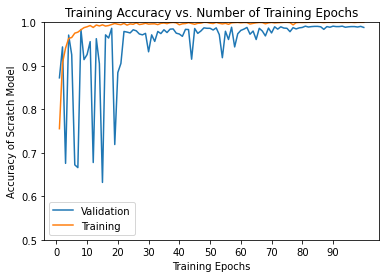

100


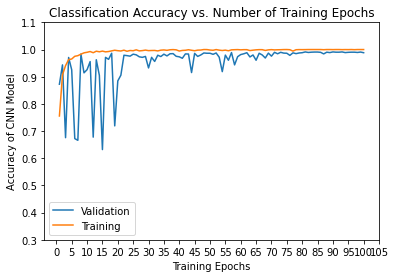

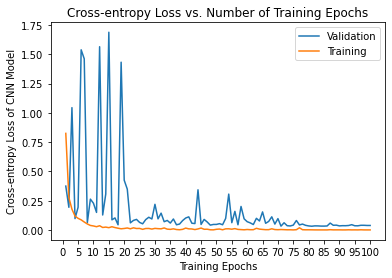

tensor([[636.,   0.,   2.],
        [  1., 657.,   5.],
        [  4.,   6., 743.]])
[641. 663. 750.]
[[0.9968652  0.         0.0031348 ]
 [0.0015083  0.9909502  0.00754148]
 [0.00531209 0.00796813 0.9867198 ]]





In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet(num_class, in_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=1e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            _, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-unet_3D3D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
runs = 1
# num_epochs=15
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname11 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname11,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")

shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.7,1.1))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Total Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Total Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

train_loss = [h for h in CE_train]
val_loss = [h for h in CE_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname32 = 'CE-loss_curve_'+str(runs)+'.png'
plt.savefig(fname32)
plt.show()

train_loss = [h for h in MSE_train]
val_loss = [h for h in MSE_val]
plt.title("MSE Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("MSE Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname33 = 'MSE-loss_curve_'+str(runs)+'.png'
plt.savefig(fname33)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-unet_80rech_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',title = '3DCNN UNet - 3D Input')

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [ ]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-4]))
# scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
# list(scratch_model.children())

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(valpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, learning_rate=200,early_exaggeration = 50, n_iter=2000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK-293','HeLa','MCF-7']


In [ ]:
target_ids = range(len(outputlist))
plt.figure()
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

In [ ]:
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model = scratch_model.to(device)
scratch_model.eval()

In [ ]:
CellName = ['Granulocyte','Lymphocyte','Monocyte']
ImgTensor, Label = image_datasets['val'].__getitem__(2)
image = np.squeeze(ImgTensor.numpy())
print('Ground Truth Cell Type: ', CellName[Label])
DisplayImage(image,image.min(),image.max())

In [ ]:
inputs = torch.unsqueeze(ImgTensor,0).to(device)
[output,prediction] = scratch_model(inputs)
# output = output.squeeze()
output = output.squeeze()
output = output.cpu().clone().detach().numpy()
_, preds = torch.max(prediction, 1)
preds = preds.cpu().clone().detach()

In [ ]:
# print(output/output.max())
print(output.max())
print(output.shape)
print('Predicted Cell Type: ', CellName[preds])
image = np.squeeze(output)
DisplayImage(image,image.min(),image.max())